# Text Collaborative Filtering
With your best friends; Cookie Optimizers :D 

# CiteULike
## Imports

In [1]:
!python -m spacy download en

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_sm -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [2]:
import pandas as pd
import numpy as np

import spacy
from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vocab

import torch
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
from torch.autograd import Variable
from torch import nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Data Loaders

In [6]:
def condence(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr])

def readData(data, interactions, text_index, shuffle, sizes, data_path, split_sets = False):
    # Read files
    rawtext = pd.read_csv(data)
    interactions = pd.read_csv(interactions)
    interactions["user.id"] = condence(interactions["user.id"].values)
    
    # Shuffle
    if shuffle:
        iteractions = np.random.shuffle(interactions.values)
    
    # Replace doc.id with text found in text_index
    interactions["doc.id"] = [rawtext.iloc[int(idx),text_index] for idx in interactions["doc.id"]]
    
    # Split into train,val,test
    n = len(interactions)
    train_size = int(sizes[0] * n)
    val_size = int(sizes[1] * n)
    test_size = n - train_size - val_size

    train = interactions[:train_size]
    val = interactions[train_size:train_size+val_size]
    test = interactions[train_size+val_size:]
    
    # Generate unique non-rated negative samples for trainig
    uniq_items = np.unique(rawtext["doc.id"])[:-1]
    uniq_users = np.unique(train["user.id"])[:-1]
    items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)
    
    n = len(train)
    pairs = []
    while(len(pairs) < n):
        item = np.random.choice(uniq_items, size = 1)[0]
        user = np.random.choice(uniq_users, size = 1)[0]
        if (user,item) not in items:
            pairs += [(user,item,0)]
            items.add((user,item))
            
    # Add negative samples to trainig
    interactionsNegatives = np.vstack((train, pairs))
    train = pd.DataFrame(data = interactionsNegatives, columns = ["user.id","doc.id", "rating"])

    # Replace negative doc.id with text found in text_index
    train["doc.id"].loc[n:] = [rawtext.iloc[int(idx),text_index] for idx in train["doc.id"].loc[n:]]

    #shuffle negative samples into training, panda style
    if shuffle:
        train = train.sample(frac=1) 
    
    # Save into seprate files
    train.to_csv(data_path+'train.csv', header = False, index = False)
    val.to_csv(data_path+'val.csv', header = False, index = False)
    test.to_csv(data_path+'test.csv', header = False, index = False)
    
    # Clean vars
    max_length = max(len(s.split(' ')) for s in rawtext.iloc[:,text_index])
    del rawtext, interactions, n, uniq_items, uniq_users, items, pairs
    del interactionsNegatives, train, val, test
    
    # Create Text fields
    spacy_en = spacy.load('en')
    def tokenizer(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    ID = Field(sequential=False, use_vocab=False)
    TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length, tokenize=tokenizer)
    RATING = Field(sequential=False, use_vocab=False)

    train, val, test = TabularDataset.splits(
            path=data_path, train='train.csv',validation='val.csv', test='test.csv',
            format='csv', fields=[('ID', ID), ('Text', TEXT), ('Rating', RATING)])
    
    ID.build_vocab(train)
    TEXT.build_vocab(train, vectors="glove.6B.100d")
    RATING.build_vocab(train)
    
    return (train, val, test), (ID,TEXT,RATING)

In [7]:
def getLoaders(data, batch_size):
    loaders = BucketIterator.splits(
        data,
        batch_sizes=batch_size,
        repeat=False,
        sort_key=lambda x: len(x.Text),
        sort_within_batch = True)
    
    return loaders

## Model

In [19]:
class CFNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, n_hidden, l1_hidden, p_dropout):
        super(CFNN, self).__init__()
        self.n_hidden = n_hidden
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.lin1 = nn.Linear(n_hidden+embedding_dim, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.4)
        self.drop1 = nn.Dropout(0.4)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, bidirectional = True)
        self.rnnlin = nn.Linear(n_hidden*2, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
        ## Attention module
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.attn_combine = nn.Linear(n_hidden * 2, n_hidden)
        
    def forward(self, u, v, hidden, seq_lengths):
        U = self.user_emb(u)
        V = self.item_emb(v)
        
        #print(v)
        
        ## Packing, Encoding, Padding
        packed = rnn_utils.pack_padded_sequence(V, seq_lengths)
        rnnOut, (hn, cn) = self.rnn(packed, hidden)
        padded,seq_lengths = rnn_utils.pad_packed_sequence(rnnOut)
        
        #print(padded.shape, seq_lengths.shape, max_length)
        #TODO: attension
        #mask = [0]*max_length
        
        #mask = torch.from_numpy(np.array(mask)).to(device)
        #new_padded = padded[0].data + mask
        
        #padded = F.SoftMax(padded)
        
        #print(mask)
        
        mean = padded.mean(dim=0)

        #print(padded)
        
        V_rnn = F.relu(self.rnnlin(mean))
         
        ## Attention module
        #attn = self.attn(hn[0])
        
        #attn_weights = F.softmax(attn, dim=1)
        
        #attn_applied = torch.mm(attn_weights, V_rnn.t())
        
        #print(attn_applied)
        
        ## Concat users and items
        #x = torch.cat([U, attn_output], dim=1)
        #V_attn = torch.cat([V_rnn, attn_applied], dim=1)
        
        x = torch.cat([U, V_rnn], dim=1)
        
        #print(U.shape)
        #print(V.shape)
        #print(x.shape)
        
        #print(x.shape)
        #print(embedding_dim)
        #print(n_hidden)
        
        ## Classification
        #x = self.drop0(x)
        x = F.relu(self.lin1(x))
        #x = self.drop1(x)
        #batchnorm testet here
        
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        init = torch.zeros(2, batch_size, self.n_hidden).to(device)
        return (init,init)

## Training Loop

In [20]:
def count_acc(output,ratings,TP,FP,TN,FN):
    for yhat,y in zip(output.data, ratings.data):
        yhat = 0.0 if yhat < 0.5 else 1.0
        if yhat == y:
            if yhat == 1:
                TP += 1
            else:
                TN += 1
        elif yhat == 1:
            FP += 1
        else:
            FN += 1
    return TP,FP,TN,FN

def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    for data in train_loader:
        batch_size = len(data.ID)
        
        users = data.ID.long().to(device)
        items = data.Text[0].long().to(device)
        seq_lengths = data.Text[1]
        ratings = data.Rating.float().to(device) 
        ratings = ratings.unsqueeze(1)
        
        optimizer.zero_grad()
        hidden_size = model.init_hidden(batch_size)
        output = model(users, items, hidden_size, seq_lengths)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        TP,FP,TN,FN = count_acc(output,ratings,TP,FP,TN,FN)
    
    train_acc = (TP + TN)/(TP + TN + FP + FN)
    train_loss /= len(train_loader)
    return train_acc, train_loss 

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    with torch.no_grad():
        for data in val_loader:
            batch_size = len(data.ID)

            users = data.ID.long().to(device)
            items = data.Text[0].long().to(device)
            seq_lengths = data.Text[1]
            ratings = data.Rating.float().to(device) 
            ratings = ratings.unsqueeze(1)
            
            hidden_size = model.init_hidden(batch_size)
            output = model(users, items, hidden_size, seq_lengths)
            loss = criterion(output, ratings)
            
            val_loss += loss.item()
            TP,FP,TN,FN = count_acc(output,ratings,TP,FP,TN,FN) 
                        
    val_acc = (TP + TN)/(TP + FN + TN + FN)
    val_loss /= len(val_loader)
    return val_acc, val_loss

def train_model(train_loader, val_loader, max_epochs, batchsize, model, criterion, optimizer, modelpath=None):
    # check path for early stopping
    if modelpath != None:
        patience_count = 0
        torch.save(model, modelpath)
    
    # Train model
    best_loss = (-1, -1, 1e15, -1, -1)
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    
    for epoch in range(1, max_epochs + 1):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        val_acc, val_loss = validate(model, val_loader, criterion)
        
        train_accs += [train_acc]
        train_losses += [train_loss]
        val_accs += [val_acc]
        val_losses += [val_loss]
        print('\n',f'Epoch {epoch}:')
        print(f' Train average loss: {f"{train_loss:3.5f}":>9s} | Validation average loss: {val_loss:3.5f}')
        print(f' Train average acc: {f"{train_acc:3.5f}":>10s} | Validation average acc: {val_acc:>4.5f}')
        
        # Early stopping
        if val_loss < best_loss[2]:
            best_loss = (epoch, train_loss, val_loss, train_acc, val_acc)
            
            if modelpath != None:
                patience_count = 0
                torch.save(model, modelpath)
        if modelpath != None:
            if patience_count == 10:
                model = torch.load(modelpath)
                break
            else:
                patience_count += 1
    
    # Plot loss and accuracy
    plt.plot(range(1,epoch+1), val_losses, color='b')
    plt.plot(range(1,epoch+1), train_losses, color='g')
    plt.axvline(x=best_loss[0], color='r')
    plt.show()
    plt.plot(range(1,epoch+1), val_accs, color='b')
    plt.plot(range(1,epoch+1), train_accs, color='g')
    plt.axvline(x=best_loss[0], color='r')
    plt.show()
    print(f'Best validation loss at epoch {best_loss[0]}')
    print(f'Train loss: {f"{best_loss[1]:3.5f}":>9s} | Validation loss: {best_loss[2]:3.5f}')
    print(f'Train acc: {f"{best_loss[3]:3.5f}":>10s} | Validation acc: {best_loss[4]:>4.5f}')
    
    # return loaded model if early stop otherwise, finished model.
    return model

## Parameters

In [21]:
# Data params
data = '../datasets/citeulike/raw-data.csv'
interactions ='../datasets/citeulike/user-info-small.csv'
#interactions = '../datasets/citeulike/user-info.csv'
text_index = 1
shuffle_data = True
sizes = [0.7, 0.2, 0.1]
data_path = '../datasets/citeulike/'
batch_size = (31,32,33)

In [22]:
# Data from params
data, fields = readData(data, interactions, text_index, shuffle_data, sizes, data_path, False)
(ID,TEXT,RATING) = fields

In [23]:
# Model parans
num_users = len(ID.vocab.itos)
num_items = TEXT.vocab.vectors.size()[0]
embedding_dim = TEXT.vocab.vectors.size()[1] #100?
RNN_n_hidden = 101
l1_hidden = 102
p_dropout = 0.3

In [24]:
# model from params
model = CFNN(num_users, num_items, embedding_dim, RNN_n_hidden, l1_hidden, p_dropout).to(device)

In [25]:
# Training params
modelpath = '../torch_models/citeulike/best.pth'
max_epochs = 100
batch_size = (31,32,33) # defined in data params
learning_rate = 0.001
weight_decay = 1e-6
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [26]:
(train_loader, val_loader, test_loader) = getLoaders(data, batch_size)

In [27]:
# Print info on text data
print('Text fields:')
#print('keys of TEXT.vocab:', list(TEXT.vocab.__dict__.keys()))
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "the" appear in the dataset:', TEXT.vocab.freqs['the'])

# Print info on model and loaders
ls = [len(l) for l in [train_loader, val_loader, test_loader]]
mbls = max([len(str(l)) for l in ls])
mls = max([len(str(l*batch_size[i])) for i,l in enumerate(ls)])

print("\n", model, "\n")
print(f"Amount of batches in training set:   {ls[0]:{mbls}d} | Total samples: {ls[0]*batch_size[0]:{mls}d}")
print(f"Amount of batches in validation set: {ls[1]:{mbls}d} | Total samples: {ls[1]*batch_size[1]:{mls}d}")
print(f"Amount of batches in testing set:    {ls[2]:{mbls}d} | Total samples: {ls[2]*batch_size[2]:{mls}d}")

Text fields:
 size of vocabulary: 5096
 vocabulary's embedding dimension: torch.Size([5096, 100])
 no. times the "the" appear in the dataset: 924

 CFNN(
  (user_emb): Embedding(51, 100)
  (item_emb): Embedding(5096, 100)
  (lin1): Linear(in_features=201, out_features=102, bias=True)
  (lin2): Linear(in_features=102, out_features=1, bias=True)
  (drop0): Dropout(p=0.4)
  (drop1): Dropout(p=0.4)
  (rnn): LSTM(100, 101, bidirectional=True)
  (rnnlin): Linear(in_features=202, out_features=101, bias=True)
  (sigmoid): Sigmoid()
  (attn): Linear(in_features=101, out_features=101, bias=True)
  (attn_combine): Linear(in_features=202, out_features=101, bias=True)
) 

Amount of batches in training set:   97 | Total samples: 3007
Amount of batches in validation set: 14 | Total samples:  448
Amount of batches in testing set:     7 | Total samples:  231


## Train Model


 Epoch 1:
 Train average loss:   0.60452 | Validation average loss: 0.60954
 Train average acc:    0.65997 | Validation average acc: 0.42809

 Epoch 2:
 Train average loss:   0.56463 | Validation average loss: 0.65561
 Train average acc:    0.69378 | Validation average acc: 0.44013

 Epoch 3:
 Train average loss:   0.50711 | Validation average loss: 0.80853
 Train average acc:    0.74766 | Validation average acc: 0.38862

 Epoch 4:
 Train average loss:   0.40026 | Validation average loss: 0.74700
 Train average acc:    0.81560 | Validation average acc: 0.43529

 Epoch 5:
 Train average loss:   0.28221 | Validation average loss: 1.13283
 Train average acc:    0.87316 | Validation average acc: 0.38188

 Epoch 6:
 Train average loss:   0.18403 | Validation average loss: 1.51981
 Train average acc:    0.92771 | Validation average acc: 0.34913

 Epoch 7:
 Train average loss:   0.12943 | Validation average loss: 1.47129
 Train average acc:    0.95080 | Validation average acc: 0.43049

 Epoc

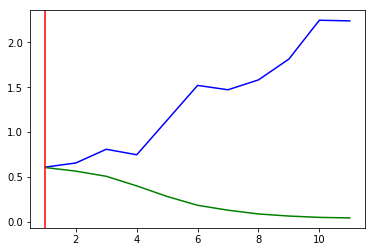

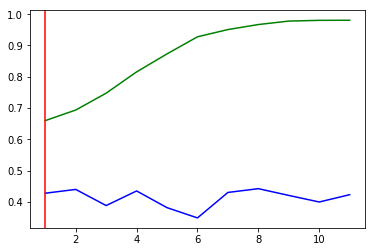

Best validation loss at epoch 1
Train loss:   0.60452 | Validation loss: 0.60954
Train acc:    0.65997 | Validation acc: 0.42809


In [28]:
model_trained = train_model(train_loader,
                            val_loader,
                            max_epochs, 
                            batch_size, 
                            model, 
                            criterion, 
                            optimizer, 
                            modelpath)

## Test Model

In [29]:
model_trained.eval()
test_loss = 0
TP,FP,TN,FN = 0,0,0,0
with torch.no_grad():
    for data in val_loader:
        batch_size = len(data.ID)

        users = data.ID.long().to(device)
        items = data.Text[0].long().to(device)
        seq_lengths = data.Text[1]
        ratings = data.Rating.float().to(device) 
        ratings = ratings.unsqueeze(1)

        hidden_size = model.init_hidden(batch_size)
        output = model(users, items, hidden_size, seq_lengths)
        loss = criterion(output, ratings)

        test_loss += loss.item()
        TP,FP,TN,FN = count_acc(output,ratings,TP,FP,TN,FN) 

test_acc = (TP + TN)/(TP + FN + TN + FN)
test_loss /= len(test_loader)

# UNCOMMENT ONLY WHEN MODEL IS COMPLETELY FINISHED
#print(f'Final test average loss: {test_loss} | average acc: {test_acc}')